## Project: **Tracking Vehicles on a Road** 
***

In this project, I will perform vehicle tracking on road recordings. This project is provided within Udacity Self driving Car Engineer Nanodegree program. The provided dataset consists of road recordings where the a couple vehicles are visible, as well as many pictures (vehicles and non vehicles) for the training of the classifier. The goal is to compute and draw bounding boxes on the visible vehicles on the video.

First, I will try and apply a few image processing techniques on single images, observe the results, and then proceed to build a pipeline that can be applied to a video stream. 

---  

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

In [1]:
# Importing the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Import an example image
image = mpimg.imread('bbox-example-image.jpg')

### 0. Taking a look at the given dataset
Let us take a look at the different car images, and build a function that gives us some insight on the number of vehicle images in the given dataset

In [ ]:
# Let us first instanciate the different paths
path_non_vehicles ='./non-vehicles'
path_vehicles = './vehicles'
image_dir = './Images'

# Let us count the number of images for each category
non_vehicles = os.listdir(path_non_vehicles)
vehicles = os.listdir(path_vehicles)
images = os.listdir(image_dir)

In [ ]:
# Define a function to compute some characteristics of the dataset 
def data_look(car_list, notcar_list, image_dir):
    """
    Computes some basic characteristics of the dataset.
    Returns a dictionnary containing the characteristics.
    """

    # numbers
    data_dict = {}
    data_dict["num_cars"] = len(car_list)
    data_dict["num_notcars"] = len(notcar_list)

    # get the shape of the images
    test_img = mpimg.imread(image_dir + '/' + car_list[0])
    data_dict['image_shape'] = np.shape(test_img)

    # data type
    data_dict['data_type'] = type(test_img)

    return data_dict



In [ ]:
# Let us get a look at the characteristics of our dataset
print(data_look(vehicles, non_vehicles, image_dir))

{'n_cars': 6939,
 'n_notcars': 8968,
 'image_shape': (64, 64, 3),
 'data_type': numpy.ndarray}

### 1. Template Matching

Detecting a car using template matching: a template of the car we're searching for is given, and we use this template to search for the car in the image. We're essentially sweeping the template all over the image to find a correspondence.

In [14]:
# template list
templist = ['templates/cutout1.jpg', 'templates/cutout2.jpg', 'templates/cutout3.jpg',
            'templates/cutout4.jpg', 'templates/cutout5.jpg', 'templates/cutout6.jpg']

def find_matches(img, template_list):
    """
    Iterates over the given list of templates and find the best match for each template.
    Returns a list of bounding boxes corresponding to each match.
    """
    bboxes = []
    img_copy = img.copy()
    for template in template_list:
        # read the template
        tpl = mpimg.imread(template)
        height, width, _ = np.shape(tpl)

        # search the image and find the best match
        res = cv2.matchTemplate(img, tpl, method = 3)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left_vertex = max_loc

        # get the bounding box
        bb = (max_loc, (max_loc[0] + width, max_loc[1] + height))
        bboxes.append(bb)
    
    return bboxes

# Apply to the list of templates
bboxes = find_matches(image, template_list=templist)

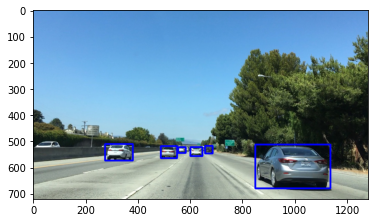

In [16]:
# Let us draw the results: It works !

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draws the given bounding boxes on the given image
    Returns the image drawn.
    """
    img_copy = img.copy()

    for bb in bboxes:
        (x1, y1), (x2, y2) = bb
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thick)

    return img_copy

result = draw_boxes(image, bboxes)
plt.imshow(result)

### 2. Extracting Features
Let us see which types of features characterize our car pictures the best. The idea here is to test some classic "handcrafted" features and see how well they perform when it comes to searching for cars in a picture.

Histograms of Color: the idea is to build a histogram of the pixel intensities in the car image. This is a representation of the distribution of pixel intensities accross the image for each channel. Since our images contain three channels, we compute one histogram per channel (even though we leave some options for computing histograms only for specific channels).
After obtaining our three histograms, we can flatten and concatenate them to obtain a feature vector. 

In [17]:
def color_histogram(img, color_space = 'RGB', nbins = 32, range = (0, 256)):
    """
    Computes the color histogram of each channel separately, as well as the concatenated feature vector.
    Returns the channel histograms, the centers of the bins and the feature vector.
    """

    # Converting the image to the correct color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img) 


    # Compute histograms for each channel
    hist_ch1 = np.histogram(feature_image[:,:,0], bins=nbins, range=range)
    hist_ch2 = np.histogram(feature_image[:,:,1], bins=nbins, range=range)
    hist_ch3 = np.histogram(feature_image[:,:,2], bins=nbins, range=range)

    # Compute bin centers
    bin_centers = (hist_ch1[1][1:] + hist_ch1[1][0:len(hist_ch1) - 1])/2

    # Concatenate the histograms into the feature vector
    hist = np.concatenate((hist_ch1[0], hist_ch2[0], hist_ch3[0]))

    return hist_ch1, hist_ch2, hist_ch3, bin_centers, hist

In [ ]:
# Execute this cell to see the results !
rhist, ghist, bhist, bin_centers, hist = color_histogram(image)

# Plotting the results
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

Spatial Binning : the idea is to retain some of the raw pixel intensities. Indeed, the previous method discards the individual pixel intensities. One way to add some representation of the raw pixel intensities into the feature vector (without getting an extra large vector) is to downsize the car image and add the resulting flattened image to the feature vector. In a way, this is like image compression.

In [19]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    """
    Performs spatial binning on the image.
    Returns the obtained feature vector
    """
    # Converting the image to the correct color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)             

    # Downsize the image and flatten it
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

In [ ]:
# Execute this cell to see the results !
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot the feature vector
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

Histogram of Oriented Gradient: this technique has the advantage of being robust to color changes. Since it relies on the very structure of the image, it is more robust than the previous features in many situations. The principle of this technique is to extract the gradient of the intensity in an image. The gradient at each pixel represents the direction of the highest intensity increase, and is obtained by applying a kernel on the image. Once the gradient at each pixel is obtained, we can then compute an histogram of the directions of these gradients: this will characterize the distribution of gradient orientations across the image, which is independant of the colors in the image. Once the histograms are obtained, we can concatenate them into a feature vector

In [23]:
def get_hog_features(img, orient = 9, color_space = 'RGB', pix_per_cell = 8, cell_per_block = 2, vis=False, feature_vec=True, transform_sqrt = False, channels = [0, 1, 2]):
    
    """
    Computes the histogram of oriented gradients (HOG) of an image.
    Returns the feature vector.
    """
    
    # Converting the image to the correct color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)    

    # Indicate the channel axis
    channel_axis = None
    if len(np.shape(img)) == 3:
        channel_axis = 2
    
    # If the gradient is to be computed for specific channels
    if channels != None:
        vec = np.array([])
        for channel in channels:
            ft_image = feature_image
            
            # get the histogram using the hog function of the skimage module 
            hog_features = hog(ft_image[:,:,channel:channel+1], orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                            cells_per_block=(cell_per_block, cell_per_block), 
                            visualize=False, feature_vector=feature_vec, channel_axis = channel_axis,
                            block_norm="L2-Hys", transform_sqrt = transform_sqrt)

            # stack the HOG features for each channel
            vec = np.hstack((vec, hog_features))
        
        # return the feature vector
        return vec
    
    # If the gradient is to be computed for all the channels
    ft_image = feature_image
    hog_features, hog_image = hog(ft_image, orientations=orient,
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block), 
                    visualize=True, feature_vector=feature_vec, channel_axis = channel_axis,
                    block_norm="L2-Hys", transform_sqrt = transform_sqrt)
   
    # If visualization is required
    if vis:
        return hog_features, hog_image
    
    # return the feature vector
    return hog_features


Let us now build the main function that will extract all the important features from our images. This function uses some of our previous feature extractors to construct a discriminative feature vector.

In [25]:
# Given a list of images, we extract their feature vectors.
def extract_features(imgs, cspace='LUV', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), pix_per_cell = 8, cell_per_block = 2, orient = 9, channels = [0, 1, 2]):
    """
    This function combines different feature extractors and builds the resulting feature vector for each image in the given list
    """

    # initializing the counter
    i = 0

    for img in imgs:
        
        # the list can be a list of images or a list of paths to those
        if type(img) == str:
            # list of paths
            image = mpimg.imread('./Images/' + img)
        else:
            # list of images
            image = img
        
        # Converting the image to the correct color space
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
    
        # spatial binning
        bin_spatial_vectors = bin_spatial(feature_image, color_space= cspace, size=spatial_size)
        
        # color histogram
        _,_,_,_, color_hist = color_histogram(feature_image, color_space= cspace, nbins = hist_bins, range = hist_range)
        
        # histogram of gradients
        hog_features = get_hog_features(feature_image, orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, color_space= cspace, vis=False, 
            feature_vec=True, transform_sqrt = False, channels=channels)

        # concatenated feature vector
        concatenated_feature = np.hstack((bin_spatial_vectors, color_hist, hog_features))
        
        # initialization of the feature array
        if i == 0:
            n = np.shape(concatenated_feature)
            features = np.empty((len(imgs), n[0]))
            features[i] = concatenated_feature
            i += 1
            
        # filling the feature array
        else:
            features[i] =  concatenated_feature
            i += 1
    
    return features

### 3. Processing the features: implementing and training a classifier

Now that we know how to extract relevant features from a template of a car, we need to build a classifier that can detect if a given image corresponds to the template of a car or not. To do so, I am using a classic machine learning classifier: an Support Vector Machine (or SVC: support vector classifier). I am training this classifier on a dataset of vehicles and not vehicles templates.

I could perform this task using a convolutionnal neural network, but the idea of this project is to explore classical computer vision techniques (because of course all of the above could be performed simply using a neural network, the feature extraction process would then be "learned" and not handcrafted) rather than use deep learning.

Let us define the function that will implement and train our classifier.

In [26]:
def train_classifier(vehicles, non_vehicles, cspace, spatial_size, hist_bins, hist_range, channels = [0, 1, 2], orient = 9):
    """
    This function takes in a set of vehicle and non vehicle templates and trains a classifier to separate them.
    """
    
    # Let us first extract the features from each category
    car_features = extract_features(vehicles, cspace, spatial_size,
                        hist_bins, hist_range, orient = orient, channels = channels)
    notcar_features = extract_features(non_vehicles, cspace, spatial_size,
                        hist_bins, hist_range, orient = orient, channels = channels)

    # We can now define the labels of our examples
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Let us regroup all the previously extracted feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Divide our dataset into a training and testing set
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

    # To facilitate training, we build a scaler fitted to our training data
    X_scaler = StandardScaler().fit(X_train)

    # We can now scale the training and testing data
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    
    # Instantiate our Support Vector Machine
    svc = LinearSVC()

    # Train the SVM
    svc.fit(scaled_X_train, y_train)

    print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
    print('Train Accuracy of SVC = ', svc.score(scaled_X_train, y_train))
    return svc, X_scaler, X, y

In [28]:
# After careful testing, the following parameters appear to be the most effective to perform feature extraction and facilitate the training of the SVM
color_space = 'LUV'
orient = 9  # number of orientation categories for the HOG feature extractor
pix_per_cell = 8
cell_per_block = 2
hog_channel = [0,1,2]
spatial_size=(8, 8) 
hist_bins = 64  # number of bins for the color histogram feature extractor
hist_range = (0, 128)


# Training our classifier
svc, X_scaler, X, y = train_classifier(vehicles, non_vehicles, cspace=color_space, spatial_size=spatial_size, 
                                        hist_bins=hist_bins, hist_range=hist_range, channels=hog_channel, orient = orient)



c:\Users\Yska\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy of SVC =  0.9949717159019484
Train Accuracy of SVC =  1.0


As you can see above, the results are pretty good !

### 4. Implementing a sliding window technique

The classifier that we trained is tuned to recognize car templates: this means that it cannot classify an entire image, it needs to process car templates. Thus, we need to implement a sliding window process that will divide the image into bounding boxes that fit the size of a car, and feed those extracted templates to the classifier

For now, we simply swipe the image with a fixed window size, extract the template and feed it to the classifier.

In [29]:
# Building our sliding window technique: we first compute the coordinates of all the possible bounding boxes of the given size
# 
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    This function computes the coordinates of all the possible bounding boxes on the images
    """
    
    # If x and y start/stop positions are not given, we consider the entire image
    x_start_stop[0], y_start_stop[0] = x_start_stop[0] or 0, y_start_stop[0] or 0
    x_start_stop[1], y_start_stop[1] = x_start_stop[1] or np.shape(img)[1], y_start_stop[1] or np.shape(img)[0]
    
    # computing the size of the region to consider
    region_width = x_start_stop[1] - x_start_stop[0]
    region_height = y_start_stop[1] - y_start_stop[0]

    # deducing the step to take between windows depending on the window size and the overlap
    pixel_step_width = int(xy_window[0] - (xy_overlap[0] *  xy_window[0]))
    pixel_step_height = int(xy_window[1] - (xy_overlap[1] * xy_window[1]))

    # deducing the number of windows in x and y
    nb_windows_x = int(1 + (region_width - xy_window[0])/pixel_step_width)
    nb_windows_y = int(1 + (region_height - xy_window[1])/pixel_step_height)

    # Initialize the window list
    window_list = []

    for idx_x in range(nb_windows_x):

        # taking a step in x 
        x = x_start_stop[0] + idx_x * pixel_step_width
        
        for idx_y in range(nb_windows_y):
            # taking a step in y
            y = y_start_stop[0] + idx_y * pixel_step_height
            
            # computing the window coordinates
            window = ((x, y), (x + xy_window[0], y + xy_window[1]))
            
            # adding the window to the list
            window_list.append(window)

    return window_list, nb_windows_x, nb_windows_y

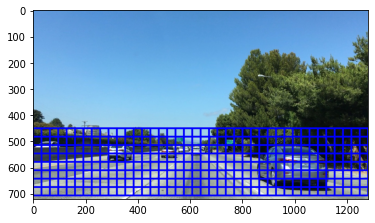

In [ ]:
# Now that we can compute all the possible bounding boxes on an image, let us see the results
image = mpimg.imread('bbox-example-image.jpg')
windows, a, b = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

# On this image, we discard all the part that does not correspond to the road: that is why the upper half does not contain any bounding box
# On the result, the bounding boxes seem small: they are in fact bigger but they overlap, which creates a smaller grid                     
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

Now that we have al the possible bounding boxes, let us use the classifier to keep only those which are likely to contain a vehicle

In [ ]:
# create a function that is given an image and a list of windows, and returns the windows for which you have a car recognized

def compute_bounding_boxes(image, windows, scaler, classifier, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), pix_per_cell = 8, cell_per_block = 2, orient = 9, channels = [0, 1, 2]):
    """
    Given an image and a list of bounding boxes, this function extracts the templates and uses a classifier to retain the bounding boxes corresponding to a vehicle.
    """
    # Copying the original image and normalizing
    img_cop = np.copy(image)
    img = img_cop.astype(np.float32)/255
    
    # initializing the list of bounding boxes to keep
    cars = []

    # going throught the list of bounding boxes
    for window in windows:

        # crop the image using the bounding box
        ((x1, y1), (x2, y2)) = window
        img_crop = cv2.resize(img[y1:y2,x1:x2], (64,64))

        # compute the features
        vec = extract_features([img_crop], cspace, spatial_size, hist_bins, hist_range, pix_per_cell, cell_per_block, orient, channels)

        # scale the features
        scaled_vec = scaler.transform(vec)
        
        # apply the classifier
        is_car = classifier.predict(scaled_vec)

        # depending on the result, add it to the return list
        if bool(is_car):
            cars.append(window)
    
    return cars

inside bounding_boxes 0.8598039
inside extract_features 86.02897
inside bin_spatial 86.02897
inside color_histogram 86.02897
inside get_hog 86.02897
inside bounding_boxes 0.8598039
inside extract_features 86.02897
inside bin_spatial 86.02897
inside color_histogram 86.02897
inside get_hog 86.02897
inside bounding_boxes 0.8598039
inside extract_features 86.02897
inside bin_spatial 86.02897
inside color_histogram 86.02897
inside get_hog 86.02897
inside bounding_boxes 0.87647057
inside extract_features 86.328064
inside bin_spatial 86.328064
inside color_histogram 86.328064
inside get_hog 86.328064
inside bounding_boxes 0.87647057
inside extract_features 86.328064
inside bin_spatial 86.328064
inside color_histogram 86.328064
inside get_hog 86.328064
inside bounding_boxes 0.87647057
inside extract_features 86.328064
inside bin_spatial 86.328064
inside color_histogram 86.328064
inside get_hog 86.328064
inside bounding_boxes 0.87647057
inside extract_features 86.328064
inside bin_spatial 86.32

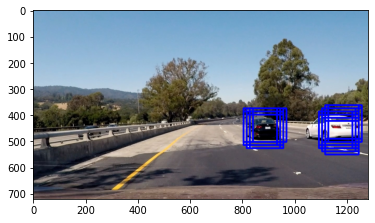

In [21]:
# Let us now test how well our pipeline works

# define a scaler:
svc, X_scaler, X, y = train_classifier(vehicles, non_vehicles, cspace='LUV', spatial_size=(8, 8), hist_bins=64, hist_range=(0, 128))

# grab the image
image = mpimg.imread('test_image.jpg')

# compute the windows
windows, a, b = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 656], 
                    xy_window=(128, 128), xy_overlap=(0.9, 0.9))
# compute the bounding boxes
bboxes = compute_bounding_boxes(image, windows, X_scaler, svc, cspace='LUV', spatial_size=(8, 8), hist_bins=64, hist_range=(0, 128), channels = [0, 1, 2])

# let us see the result !
result = draw_boxes(image, bboxes)
plt.imshow(result)

### 5. Improving our sliding window technique and completing the pipeline

Our current sliding window technique is computationally expensive: it requires the computation of the HOG features for each window ! A smarter way to implement things would be to compute the HOG features for the entire image, and from that deduce the HOG feature vector corresponding to each window, such that we compute the HOG features only once.

On top of that, it is easy to see that the size of the windows should depend on the image coordinates: the more we approach the horizon line, the smaller the window. Thus, we add the possibility to scale up or down the image.

Let us build a general function containing the new implementation of the sliding window technique as well as the rest of the pipeline (feature extraction and classification)

In [ ]:
# Let us define a single function that performs feature extraction (with hog subsampling) and makes predictions
def detect_vehicles(img, ystart, ystop, scale, svc, X_scaler, color_space = 'LUV', pix_per_cell = 8, cell_per_block = 2, orient = 9, spatial_size=(8, 8), hist_bins=64, hist_range = (0, 128)):
    """
    Given a specific image, this function determines the coordinates of the bounding boxes containing cars and returns the drawn image.
    """

    # Initialization
    bboxes = []
    img_tosearch = img[ystart:ystop,:,:]
    draw_img = np.copy(img)
    
    # Checking the image format
    if np.max(img_tosearch) > 1.0:
        img = img_tosearch.astype(np.float32)/255.0
    else:
        img = np.copy(img_tosearch)
    
    
    # Converting the image to the correct color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    
    # potential rescaling
    if scale != 1:
        imshape = np.shape(feature_image)
        feature_image = cv2.resize(feature_image, (int(imshape[1]/scale), int(imshape[0]/scale)))

    
    # Isolate the channels of the image
    ch1 = feature_image[:,:,0]
    ch2 = feature_image[:,:,1]
    ch3 = feature_image[:,:,2]

    # Computing the number of blocks
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # Computing the number of steps to take in x and y
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute HOG features for the entire image ONLY ONCE
    hog1 = get_hog_features(ch1, orient,  color_space = 'RGB', pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=False, channels = None)
    hog2 = get_hog_features(ch2, orient, color_space = 'RGB', pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=False, channels = None)
    hog3 = get_hog_features(ch3, orient, color_space = 'RGB', pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=False, channels = None)
    
    # For every window, extracting features and retrieving the HOG features
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # Position of the window to consider
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Retrieve HOG features for this window
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Coordinates of the upper left corner
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = int(xleft*scale)
            ytop_draw = int(ytop*scale)
            win_draw = int(window*scale)

            # Extract the image patch
            subimg = cv2.resize(feature_image[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins, range=hist_range)[-1]

            # Build the feature vector, scale it and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            # Store the bounding boxe if it contains a vehicle
            if test_prediction == 1:
                xbox_left = int(xleft*scale)
                ytop_draw = int(ytop*scale)
                win_draw = int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return draw_img, bboxes


Let us now apply our function on several test images. We change the scale depending on which section of the image we are looking at, in order to adapt the size of the windows to the size of the potential vehicles.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


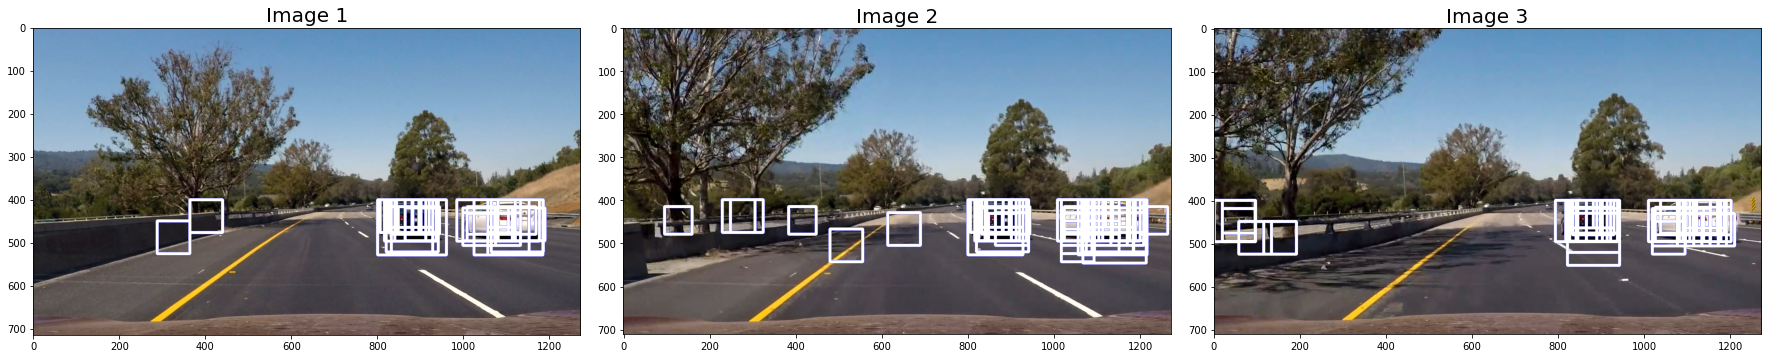

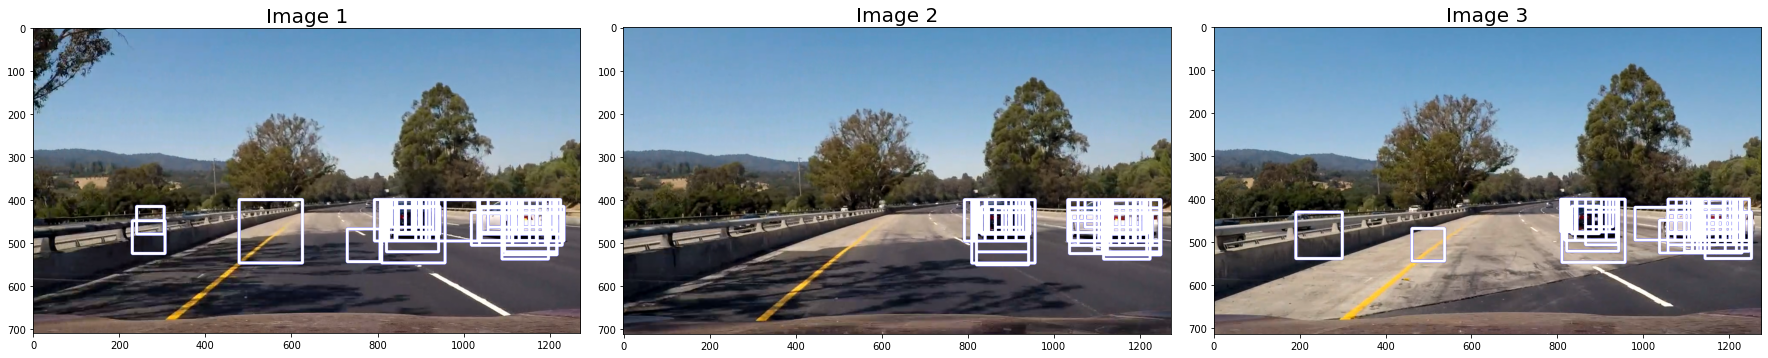

In [34]:
def compute_windows(image, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range):
    """
    This function computes the bounding boxes that seem to contain vehicles. 
    It uses scaling to adjust the size of the windows depending on the region of the image we are scanning.
    """

    # First region of scanning, with different scalings
    bboxes = []
    ystart = 400
    ystop = 500
    img = np.copy(image)
    out_img1, bbx1 = detect_vehicles(image, ystart, ystop, 1.0, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img2, bbx2 = detect_vehicles(image, ystart, ystop, 1.2, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img3, bbx3 = detect_vehicles(image, ystart, ystop, 1.5, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    
    # Second region of scanning, with different scalings
    ystart = 430
    ystop = 556 
    out_img4, bbx4 = detect_vehicles(image, ystart, ystop, 1.2, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img5, bbx5 = detect_vehicles(image, ystart, ystop, 1.7, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img6, bbx6 = detect_vehicles(image, ystart, ystop, 2.1, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    
    # Third region of scanning, with different scalings
    ystart = 400
    ystop = 556 
    out_img7, bbx7 = detect_vehicles(image, ystart, ystop, 1.9, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img8, bbx8 = detect_vehicles(image, ystart, ystop, 2, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    out_img9, bbx9 = detect_vehicles(image, ystart, ystop, 2.3, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    
    bboxes = [bbx1, bbx2, bbx3, bbx4, bbxs5, bbx6, bbx7, bbx8, bbx9]

    res = draw_boxes(img, bboxes)
    
    return res, bboxes
   

# Set the parameters
color_space = 'LUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = [0,1,2]
spatial_size=(8, 8) 
hist_bins=64 
hist_range = (0, 128)

# Get the test images
image1 = mpimg.imread('./test_images/im1.jpg')
image2 = mpimg.imread('./test_images/im2.jpg')
image3 = mpimg.imread('./test_images/im3.jpg')
image4 = mpimg.imread('./test_images/im4.jpg')
image5 = mpimg.imread('./test_images/im5.jpg')
image6 = mpimg.imread('./test_images/im6.jpg')

# Apply our sliding window technique
drawn_img1, bbx1 = compute_windows(image1, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
drawn_img2, bbx2 = compute_windows(image2, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
drawn_img3, bbx3 = compute_windows(image3, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
drawn_img4, bbx4 = compute_windows(image4, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
drawn_img5, bbx5 = compute_windows(image5, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
drawn_img6, bbx6 = compute_windows(image6, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)


def show_images(image1, image2, image3,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3"):
    """
    This function plots the given list of images
    """
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

show_images(drawn_img1, drawn_img2, drawn_img3)
show_images(drawn_img4, drawn_img5, drawn_img6)

As we can see on the picture above, there are some isolated windows that do not correspond to any cars. In order to get rid of the outliers, we can now build a heatmap and set a specific threshold to eliminate isolated windows.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


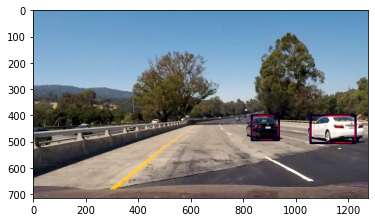

In [49]:
def update_heat_map(heatmap, bboxes, delta_x = 25, delta_y = 15):
    """
    This function updates the given heatmap with the given list of bounding boxes.
    """
    # for every bounding box, update the heatmap
    for bboxe in bboxes:
        ((x1, y1), (x2, y2)) = bboxe
        heatmap[y1-delta_y:y2+delta_y,x1-delta_x:x2+delta_x] += 1 # increase the "heat" inside the window by 1
    
    return heatmap

def threshold_map(heatmap, threshold):
    """
    This function uses a the given threshold to retain 
    only the correct windows on the heatmap
    """
    heatmap[heatmap <= threshold] = 0  # set the pixels lying in the outlier windows to 0
    return heatmap


def draw_labeled_bboxes(img, labels):
    """
    This function uses the map containing the labelled pixels 
    to plot the bounding boxes corresponding to each label on the image
    """
    # Iterate through all detected cars
    bboxes = []
    print('cars detected:', labels[1])
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the image
    return img, bboxes

def compute_heatmaps(image_list, bboxes_list, threshold):
    """
    This function computes the heatmap for every image is the given list.
    It uses the given threshold to eliminate the outliers.
    """
    results = []
    bbx = []
    # scan the entire list
    for i in range(len(image_list)):
        img = image_list[i]
        bbxes = bboxes_list[i]

        # compute the heatmap
        heatmap = np.zeros_like(img[:,:,0])
        heatmap = update_heat_map(heatmap, bbxes)
        heatmap = threshold_map(heatmap, threshold)

        # plot the heatmap and get the labels (how many cars?)
        plt.imshow(heatmap, cmap='hot')
        labels = label(heatmap)

        # Extracting the bounding boxes corresponding to each car
        draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
        plt.imshow(draw_img)
        bbx.append(bboxes)
        results.append(draw_img)
    
    return results, bbx

image_list = [image1, image2, image3, image4, image5, image6]
bboxes_list = [bbx1, bbx2, bbx3, bbx4, bbx5, bbx6]

results, bboxes = compute_heatmaps(image_list, bboxes_list, threshold = 5)
    

After applying our pipeline to the test video, we get the following result

In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="vid_output/testing_result.mp4" type="video/mp4">
</video>
""")

### 6. Smoothing the sliding window computation over time

After applying our current sliding window technique to the given video, we realize that since windows change every frame, we get a pretty "chaotic" succession of windows, which does not look good. Let us now implement a sliding window method that "smoothes" windows over time, so that we get something more "stable".

In [128]:
def smooth_bbxes(bboxes, win_size=5):
    """
    This function builds a bounding box based on an average of the previous bounding boxes (given in bboxes)
    """
    num_images = len(bboxes)
    res = []
    window = bboxes[-win_size:]  # list of passed bounding boxes to consider
    dict_average = {}
    last_img_bbx = window[-1]

    # creating a dictionnary {id_vehicle: bounding_box} for the current frame
    for i in range(len(last_img_bbx)):
        if last_img_bbx[i][1][0] - last_img_bbx[i][0][0] > 75:  # discard small bounding boxes
            dict_average[i] = []

    # for the rest of the frames, get the bounding boxes and associate them to the correct vehicle
    for bboxes_img in window:
        for i in range(len(bboxes_img)):
            if dict_average.get(i) == None:  # if that vehicle is not in the current frame, no need to add it
                continue
            
            bbx = bboxes_img[i]
            if bbx[1][0] - bbx[0][0] > 75:  # if add the bbx to the correct vehicle
                dict_average[i].append(bbx)

    # for every vehicle, compute the average bounding box
    for num_car in dict_average.keys():
        avg_x1, avg_y1, avg_x2, avg_y2 = 0, 0, 0, 0
        N = len(dict_average[num_car])
        for bbx in dict_average[num_car]:
            ((x1, y1), (x2, y2)) = bbx
            avg_x1 += x1/N
            avg_x2 += x2/N
            avg_y1 += y1/N
            avg_y2 += y2/N
        res.append(((int(avg_x1), int(avg_y1)), (int(avg_x2), int(avg_y2))))
    
    return res


def agg_heatmaps(img, bbxes, threshold):
    """
    This function computes the heatmap of a single image
    """

    # compute the heatmap
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = update_heat_map(heatmap, bbxes)
    heatmap = threshold_map(heatmap, threshold)

    plt.imshow(heatmap, cmap='hot')
    labels = label(heatmap)

    # obtain the labels and draw the resulting bounding boxes
    draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
    plt.imshow(draw_img)
    
    return draw_img, bboxes


def get_agg_bboxes(img, **kwargs):
    """
    This function implements the whole pipeline with bounding-box smoothing over a specific time window
    """

    # Getting the required parameters
    ystart = kwargs.pop('ystart', 450)
    ystop = kwargs.pop('ystop', None)
    pix_per_cell = kwargs.pop('pix_per_cell', 8)
    cell_per_block = kwargs.pop('cell_per_block', 2)
    orient = kwargs.pop('orient', 9)
    spatial_size = kwargs.pop('spatial_size', (8, 8))
    hist_bins = kwargs.pop('hist_bins', 64)
    hist_range = kwargs.pop('hist_range', (0, 128))
    threshold = kwargs.pop('threshold', 5)
    img_copy = np.copy(img)
    
    # Getting the current list of bounding boxes
    global agg_bbxs

    # Apply sliding windows and make predictions
    updated_img, bboxes = compute_windows(img, svc, X_scaler, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins, hist_range)
    image, bboxes = agg_heatmaps(img, bboxes, threshold)

    # Update the list of bounding boxes with the new ones
    agg_bbxs.append(bboxes)
    
    # Compute the average bounding box for each vehicle and draw the result
    result = draw_boxes(img_copy, smooth_bbxes(agg_bbxs, win_size = 8))

    return result

Let us now test our pipeling on a series of test images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
cars detected: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
cars detected: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
cars detected: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
cars detected: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
cars detected: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
cars detected: 2


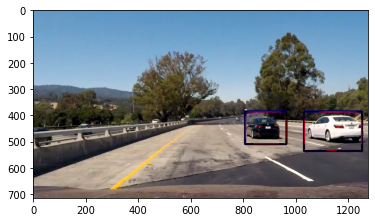

In [126]:
agg_bbxs = []

# Get the test images
image1 = mpimg.imread('./test_images/im1.jpg')
image2 = mpimg.imread('./test_images/im2.jpg')
image3 = mpimg.imread('./test_images/im3.jpg')
image4 = mpimg.imread('./test_images/im4.jpg')
image5 = mpimg.imread('./test_images/im5.jpg')
image6 = mpimg.imread('./test_images/im6.jpg')

im_list = [image1, image2, image3, image4, image5, image6]
res = []

# Execute the pipeline
for image in im_list:
    res.append(get_agg_bboxes(image))

In [100]:
# Checking that the bounding boxes have been aggregated in the list through time
print(agg_bbxs)

[[((800, 375), (964, 519)),
  ((999, 375), (1176, 520)),
  ((983, 407), (984, 504))],
 [((800, 375), (952, 520)), ((992, 375), (1232, 549))],
 [((800, 375), (952, 519)), ((999, 375), (1213, 530))],
 [((791, 375), (960, 520)), ((1011, 375), (1240, 530))],
 [((800, 375), (964, 520)), ((1015, 375), (1252, 530))],
 [((807, 375), (964, 519)), ((1031, 375), (1252, 545))]]

We can now apply our pipeline to the test video and see the results !

2
cars detected: 2
Moviepy - Building video ./vid/testing_result.mp4.
Moviepy - Writing video ./vid/testing_result.mp4



t:   5%|▌         | 2/38 [00:04<01:14,  2.06s/it, now=None]

2
cars detected: 2


t:   8%|▊         | 3/38 [00:08<01:42,  2.93s/it, now=None]

2
cars detected: 2


t:  11%|█         | 4/38 [00:12<01:54,  3.38s/it, now=None]

2
cars detected: 2


t:  13%|█▎        | 5/38 [00:16<01:59,  3.63s/it, now=None]

2
cars detected: 2


t:  16%|█▌        | 6/38 [00:23<02:29,  4.69s/it, now=None]

2
cars detected: 2


t:  18%|█▊        | 7/38 [00:27<02:19,  4.50s/it, now=None]

3
cars detected: 3


t:  21%|██        | 8/38 [00:31<02:12,  4.40s/it, now=None]

2
cars detected: 2


t:  24%|██▎       | 9/38 [00:35<02:05,  4.33s/it, now=None]

2
cars detected: 2


t:  26%|██▋       | 10/38 [00:40<02:01,  4.33s/it, now=None]

2
cars detected: 2


t:  29%|██▉       | 11/38 [00:44<01:57,  4.34s/it, now=None]

2
cars detected: 2


t:  32%|███▏      | 12/38 [00:49<01:59,  4.59s/it, now=None]

2
cars detected: 2


t:  34%|███▍      | 13/38 [00:53<01:52,  4.51s/it, now=None]

2
cars detected: 2


t:  37%|███▋      | 14/38 [00:58<01:46,  4.43s/it, now=None]

2
cars detected: 2


t:  39%|███▉      | 15/38 [01:02<01:40,  4.38s/it, now=None]

2
cars detected: 2


t:  42%|████▏     | 16/38 [01:06<01:36,  4.37s/it, now=None]

2
cars detected: 2


t:  45%|████▍     | 17/38 [01:11<01:30,  4.32s/it, now=None]

3
cars detected: 3


t:  47%|████▋     | 18/38 [01:15<01:27,  4.37s/it, now=None]

2
cars detected: 2


t:  50%|█████     | 19/38 [01:20<01:24,  4.42s/it, now=None]

2
cars detected: 2


t:  53%|█████▎    | 20/38 [01:24<01:19,  4.43s/it, now=None]

2
cars detected: 2


t:  55%|█████▌    | 21/38 [01:29<01:15,  4.46s/it, now=None]

2
cars detected: 2


t:  58%|█████▊    | 22/38 [01:33<01:11,  4.45s/it, now=None]

2
cars detected: 2


t:  61%|██████    | 23/38 [01:37<01:06,  4.43s/it, now=None]

2
cars detected: 2


t:  63%|██████▎   | 24/38 [01:42<01:02,  4.44s/it, now=None]

2
cars detected: 2


t:  66%|██████▌   | 25/38 [01:46<00:57,  4.42s/it, now=None]

2
cars detected: 2


t:  68%|██████▊   | 26/38 [01:51<00:53,  4.44s/it, now=None]

2
cars detected: 2


t:  71%|███████   | 27/38 [01:55<00:49,  4.47s/it, now=None]

2
cars detected: 2


t:  74%|███████▎  | 28/38 [02:00<00:44,  4.45s/it, now=None]

2
cars detected: 2


t:  76%|███████▋  | 29/38 [02:04<00:39,  4.44s/it, now=None]

2
cars detected: 2


t:  79%|███████▉  | 30/38 [02:08<00:35,  4.44s/it, now=None]

2
cars detected: 2


t:  82%|████████▏ | 31/38 [02:13<00:31,  4.48s/it, now=None]

2
cars detected: 2


t:  84%|████████▍ | 32/38 [02:18<00:26,  4.49s/it, now=None]

2
cars detected: 2


t:  87%|████████▋ | 33/38 [02:22<00:22,  4.55s/it, now=None]

2
cars detected: 2


t:  89%|████████▉ | 34/38 [02:29<00:21,  5.29s/it, now=None]

2
cars detected: 2


t:  92%|█████████▏| 35/38 [02:34<00:14,  4.98s/it, now=None]

2
cars detected: 2


t:  95%|█████████▍| 36/38 [02:38<00:09,  4.80s/it, now=None]

2
cars detected: 2


t:  97%|█████████▋| 37/38 [02:42<00:04,  4.65s/it, now=None]

2
cars detected: 2


t: 100%|██████████| 38/38 [02:47<00:00,  4.57s/it, now=None]

2
cars detected: 2


2
cars detected: 2


Moviepy - Done !
Moviepy - video ready ./vid/testing_result.mp4
CPU times: total: 2min 48s
Wall time: 2min 52s


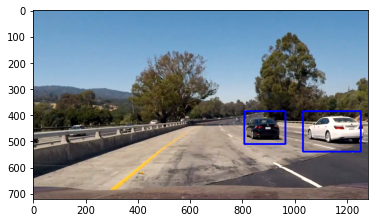

In [129]:
# Now let us apply our solution to the test video
agg_bbxs = []
# Getting the test video
test_video = VideoFileClip('test_video.mp4')
test_video_output = './vid/testing_result.mp4'
result = test_video.fl_image(get_agg_bboxes)
%time result.write_videofile(test_video_output, audio=False)


In [2]:
HTML("""
<video width="960" height="540" controls>
  <source src="vid/testing_result.mp4" type="video/mp4">
</video>
""")